In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from gzbuilder_analysis.spirals import xy_from_r_theta
import sample_generation as sg
from tqdm import tqdm

In [2]:
__file__ = '.'
loc = os.path.abspath(os.path.dirname(__file__))

In [3]:
# Base parameter definition
N_GALS = 6**2
BASE_PA = 15
INTER_GAL_SD = 10
INTRA_GAL_SD = 3
MEAN_N_ARMS = 2.75

In [4]:
gal_pas = st.truncnorm.rvs(0.1, 60, loc=BASE_PA, scale=INTER_GAL_SD,
                           size=N_GALS)
gal_n_arms = [np.random.poisson(0.75) + 2 for i in range(N_GALS)]
# map from arm to galaxy (so gal_arm_map[5] = 3 means the 5th arm is from the 3rd galaxy)
gal_arm_map = np.concatenate([
    np.tile(i, n) for i, n in enumerate(gal_n_arms)
])

print('Input galaxies:')
print(pd.DataFrame({
    'Pitch angle': gal_pas,
    'Arm number': gal_n_arms
}).describe())

Input galaxies:
       Pitch angle  Arm number
count    36.000000   36.000000
mean     24.162762    2.777778
std       5.464430    0.897969
min      16.134480    2.000000
25%      19.861895    2.000000
50%      23.048418    3.000000
75%      27.656719    3.000000
max      36.391358    5.000000


In [5]:
# Generate our galaxies
galaxies = [
    sg.gen_galaxy(gal_n_arms[i], gal_pas[i], INTRA_GAL_SD, N=100)
    for i in range(N_GALS)
]

In [6]:
# Create an array containing needed information in a stacked form
point_data = np.concatenate([
    np.stack((
        arm_T, arm_R,
        np.tile(sum(gal_n_arms[:gal_n]) + arm_n, len(arm_T)),
        np.tile(gal_n, len(arm_T))
    ), axis=-1)
    for gal_n, galaxy in enumerate(galaxies)
    for arm_n, (arm_T, arm_R) in enumerate(galaxy)
])

T, R, arm_idx, gal_idx = point_data.T
arm_idx = arm_idx.astype(int)

# ensure the arm indexing makes sense
assert sum(np.unique(arm_idx) - np.arange(sum(gal_n_arms))) == 0

In [7]:
gal_separate_fit_params = pd.Series([])
with tqdm([galaxy for galaxy in galaxies]) as bar:
    for i, gal in enumerate(bar):
        gal_separate_fit_params.loc[i] = [
            sg.fit_log_spiral(*arm)
            for arm in gal
        ]
arm_separate_fit_params = pd.DataFrame(
    [j for _, i in gal_separate_fit_params.items() for j in i],
    columns=('pa', 'c')
)
print(arm_separate_fit_params.describe())

100%|██████████| 36/36 [00:03<00:00, 11.52it/s]


               pa           c
count  100.000000  100.000000
mean    26.449808   -4.481072
std      5.470944    1.794307
min     16.369631  -11.175660
25%     22.833643   -5.377349
50%     25.904689   -4.299334
75%     29.446863   -3.113097
max     39.422839   -1.384547


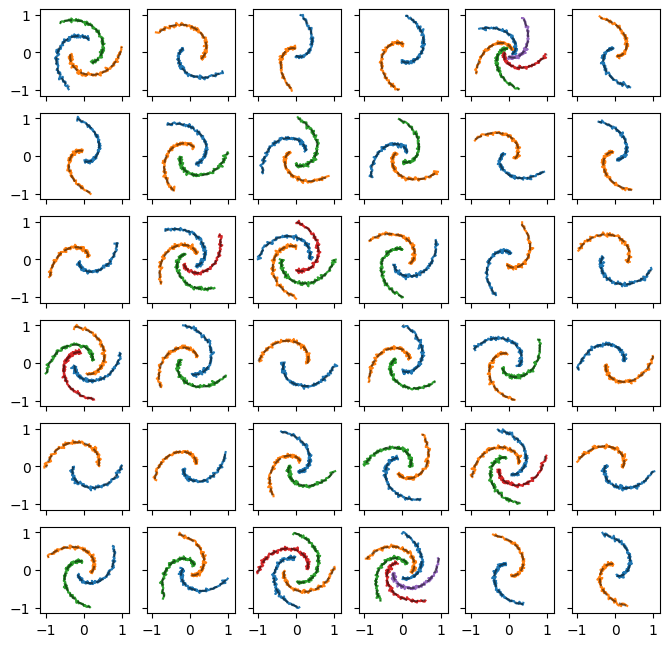

In [8]:
# plot all the "galaxies" used
s = int(np.ceil(np.sqrt(N_GALS)))
f, axs_grid = plt.subplots(ncols=s, nrows=s, sharex=True, sharey=True, figsize=(8, 8), dpi=100)
axs = [j for i in axs_grid for j in i]
for i, ax in enumerate(axs):
    plt.sca(ax)
    try:
        for p, arm in zip(gal_separate_fit_params.iloc[i], galaxies[i]):
            R_fit = sg.log_spiral(arm[0], p[0])*np.exp(p[1])
            plt.plot(*xy_from_r_theta(arm[1], arm[0]))
            plt.plot(*xy_from_r_theta(R_fit, arm[0]), 'k--', alpha=0.5)
            
    except IndexError:
        pass

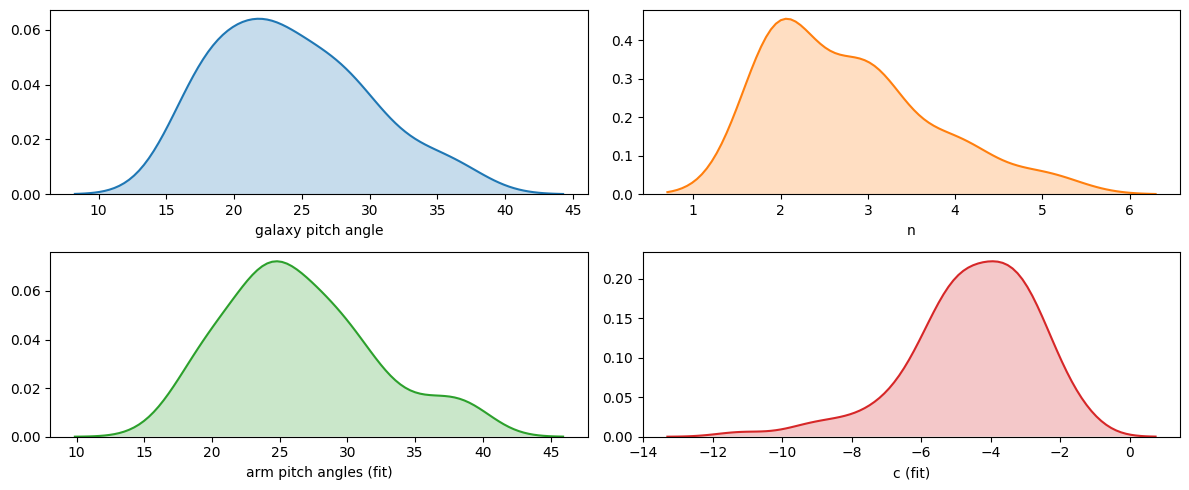

In [9]:
plt.figure(figsize=(12, 5), dpi=100)
plt.subplot(221)
sns.kdeplot(gal_pas, shade=True)
plt.xlabel('galaxy pitch angle')
plt.subplot(222)
sns.kdeplot(gal_n_arms, shade=True, color='C1')
plt.xlabel('n')
plt.subplot(223)
sns.kdeplot(arm_separate_fit_params['pa'].values, shade=True, color='C2')
plt.xlabel('arm pitch angles (fit)')
plt.subplot(224)
sns.kdeplot(arm_separate_fit_params['c'].values, shade=True, color='C3')
plt.xlabel('c (fit)')
plt.tight_layout();

In [10]:
gal_separate_fit_params.apply(lambda a: np.std(a, axis=0, ddof=1)).apply(pd.Series).mean()

0    1.307677
1    1.111045
dtype: float64

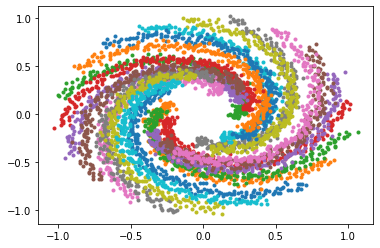

In [18]:
import os
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
from gzbuilder_analysis.spirals import xy_from_r_theta
from sample_generation import gen_galaxy

loc = os.path.abspath(os.path.dirname(__file__))

n_arms = 20  # np.random.poisson(0.9) + 2
galaxy = gen_galaxy(n_arms, 15, 5, N=250)

# plot the "galaxy" used
for (_t, _r) in galaxy:
    plt.plot(*xy_from_r_theta(_r, _t), '.')

point_data = np.concatenate([
    np.stack((arm_T, arm_R, np.tile(arm_n, len(arm_T))), axis=-1)
    for arm_n, (arm_T, arm_R) in enumerate(galaxy)
])

T, R, arm_idx = point_data.T
arm_idx = arm_idx.astype(int)

In [22]:
point_data_df = pd.DataFrame(point_data, columns=('T', 'R', 'arm_idx'))
point_data_df.describe()

,T,R,arm_idx
count,5000.000000,5000.000000,5000.000000
mean,6.892392,0.600921,9.500000
std,2.027693,0.200978,5.766858
min,2.337166,0.170736,0.000000
25%,5.321923,0.436888,4.750000
50%,6.892347,0.575087,9.500000
75%,8.463056,0.758345,14.250000
max,11.447703,1.084321,19.000000


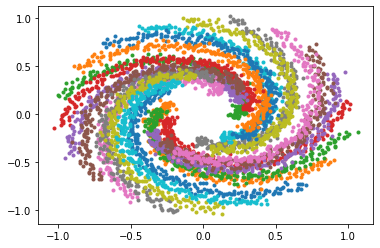

In [29]:
for i in np.unique(point_data_df.arm_idx):
    data = point_data_df.query('arm_idx == {}'.format(i))[['T' , 'R']]
    plt.plot(*xy_from_r_theta(data['R'], data['T']), '.')